<a href="https://colab.research.google.com/github/swflora/ML/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏞 합성곱 신경망

이 노트북에서는 CIFAR 데이터셋에서 합성곱 신경망(CNN)을 훈련하는 데 필요한 단계를 소개합니다.

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks

--2024-03-05 01:32:21--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2024-03-05 01:32:21 (45.8 MB/s) - ‘utils.py’ saved [771/771]



In [2]:
import numpy as np

from tensorflow.keras import layers, models, optimizers, utils, datasets
from notebooks.utils import display

## 0. 파라미터 <a name="parameters"></a>

In [3]:
NUM_CLASSES = 10

## 1. 데이터 준비 <a name="prepare"></a>

In [4]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [5]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)

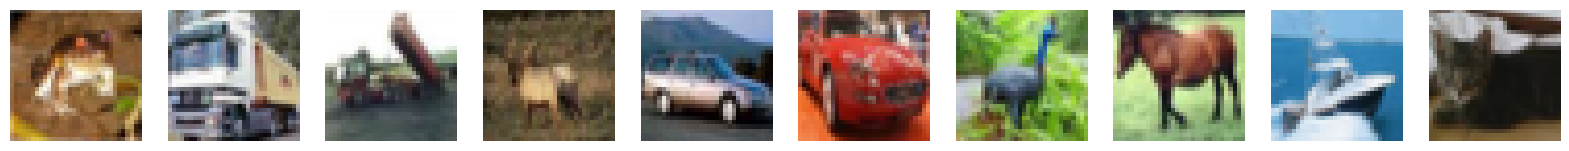

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [6]:
display(x_train[:10])
print(y_train[:10])

## 2. 모델 만들기 <a name="build"></a>

In [7]:
input_layer = layers.Input((32, 32, 3))

# 1960-70대 모델보다 업그레이드
# 차이점, Conv2D
x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(
    input_layer # 합성곱 신경망 이론 적용
)
x = layers.BatchNormalization()(x) # 과적합 방지용
x = layers.LeakyReLU()(x) #활설화 함수

# 반복하여 여러층을 쌓음
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# 층은 마음대로 쌓을 수 있음
x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# 다만 연산 시간이 늘어남
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# 출력 층(output) 영역, 1차원 배열로 정렬 -> 출력을 위해
# 이전 단계까지는 전부 2차원 배열
x = layers.Flatten()(x)# 출력 층 내부에서 다시 input

x = layers.Dense(128)(x)# 출력 층 내부에서 다시 hidden
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate=0.5)(x)

x = layers.Dense(NUM_CLASSES)(x)
output_layer = layers.Activation("softmax")(x) # 최종 출력

model = models.Model(input_layer, output_layer)

# 층을 많이 쌓았음에도 실질적으로 내부에서 연산하는 개수는 524,416개
# 효율적으로 구조를 만들어냄
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 32)        128       
 chNormalization)                                            

## 3. 모델 훈련 <a name="train"></a>

In [8]:
opt = optimizers.Adam(learning_rate=0.0005)
model.compile(
    loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

In [9]:
model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=10,
    shuffle=True,
    validation_data=(x_test, y_test),
)

Epoch 1/10
1563/1563 [==============================] - 21s 8ms/step - loss: 1.5594 - accuracy: 0.4551 - val_loss: 1.5173 - val_accuracy: 0.4600
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1304 - accuracy: 0.6017 - val_loss: 1.1429 - val_accuracy: 0.5966
Epoch 3/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.9920 - accuracy: 0.6534 - val_loss: 1.0155 - val_accuracy: 0.6430
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9108 - accuracy: 0.6834 - val_loss: 0.9699 - val_accuracy: 0.6682
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8538 - accuracy: 0.7029 - val_loss: 0.9710 - val_accuracy: 0.6777
Epoch 6/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8046 - accuracy: 0.7222 - val_loss: 1.0303 - val_accuracy: 0.6469
Epoch 7/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.7596 - accuracy: 0.7348 - val_loss: 0.8727 - val_ac

## 4. 평가 <a name="evaluate"></a>

In [10]:
# 정확도가 더 오름
model.evaluate(x_test, y_test, batch_size=1000)

10/10 [==============================] - 1s 24ms/step - loss: 0.9054 - accuracy: 0.6926


[0.9053864479064941, 0.6926000118255615]

In [11]:
CLASSES = np.array(
    [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
)

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

313/313 [==============================] - 1s 2ms/step


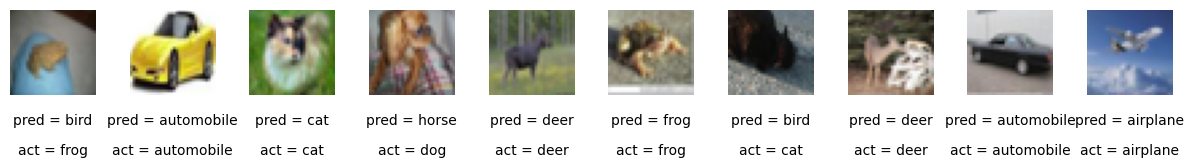

In [12]:
import matplotlib.pyplot as plt

n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(preds_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)